In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'w'
from astropy import log, constants, coordinates, units as u
import warnings
warnings.filterwarnings('ignore')
log.setLevel('ERROR')

# My functions
from mol_model import fetch_cubes, model_and_plot, list_mol_tags, get_cubes_from_mask, plot_mom0s

results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/contsub_smoothed_cubes_K/'

make: *** No targets specified and no makefile found.  Stop.


In [2]:
# Get list of all cubes
import glob
cubefns = glob.glob(f"{results}/source_ab_*.image.commonbeam.contsub.K.fits")

In [3]:
# Set coordinate of central source
crd = coordinates.SkyCoord("17:46:10.6339473267 -28:42:17.9807702398", frame='icrs', unit=(u.h, u.deg))

In [4]:
# Get only the cubes that have our line of interest in them
mol_tag = 43002 # 43511
cubes, tbl = fetch_cubes(cubefns, catalog='JPL', mol_name_pyspeckit=None, mol_tag_pyspeckit=mol_tag, parse_loc=False, ret_tbl=True)

[<Table length=47>
   FREQ      ERR    LGINT    DR    ELO     GUP   TAG   QNFMT   QN'      QN"   
   MHz       MHz   MHz nm2        1 / cm                                      
 float64   float64 float64 int64 float64  int64 int64  int64   str8     str8  
---------- ------- ------- ----- -------- ----- ------ ----- -------- --------
87596.5625  0.0149 -5.4785     3  34.4611     7  43002   304  4 1 4 3  3 1 3 3
87597.1488  0.0055 -7.2778     3  34.4611     7  43002   304  4 1 4 3  3 1 3 4
 87597.342    0.03 -4.1872     3  34.4611    11 -43002   304  4 1 4 5  3 1 3 4
 87597.342    0.03 -4.4205     3  34.4611     7 -43002   304  4 1 4 3  3 1 3 2
 87597.342    0.03 -4.3024     3  34.4611     9 -43002   304  4 1 4 4  3 1 3 3
87597.9878  0.0121 -5.4785     3  34.4611     9  43002   304  4 1 4 4  3 1 3 4
87866.8827  0.0085  -6.308     3 275.0999     9  43002   304  4 3 1 4  3 3 0 4
87866.8827  0.0085  -6.308     3 275.0999     9  43002   304  4 3 2 4  3 3 1 4
 87866.891  0.0084   -5.25     3 

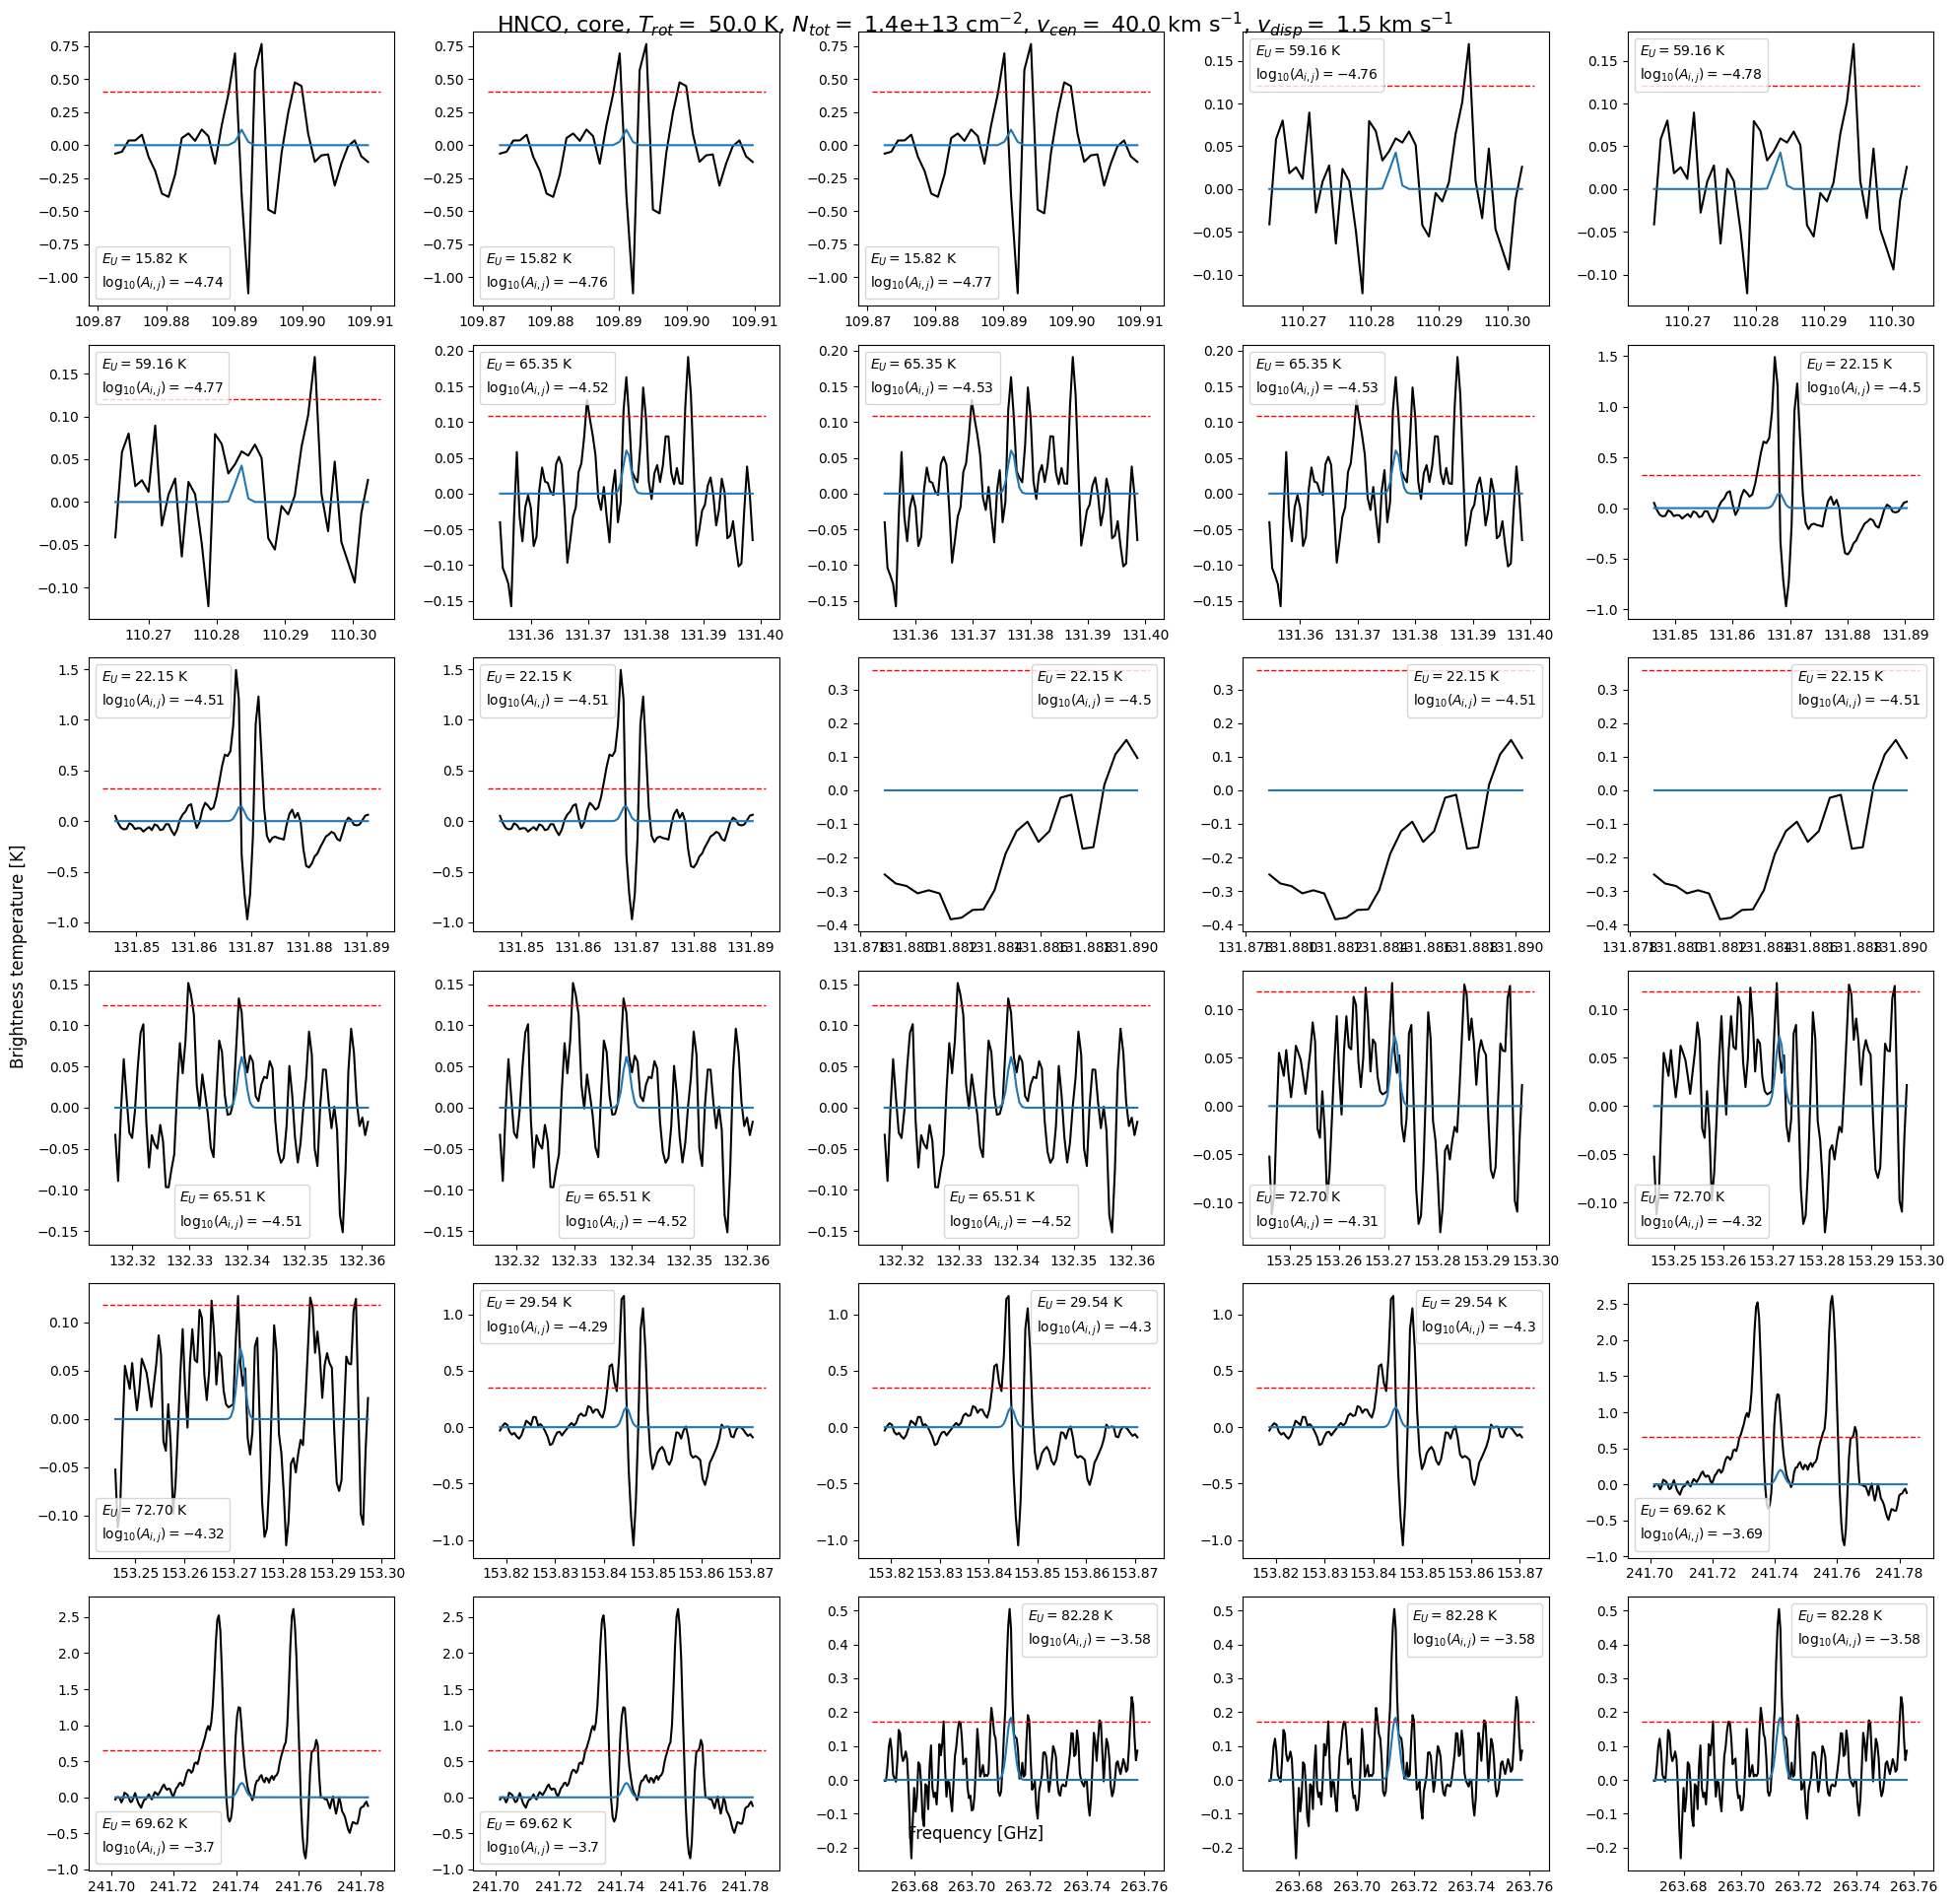

In [29]:
# Generate the model and plot the model and data spectra
freqs_mom0 = model_and_plot(cubes, temp = 50., N_tot = 1.4e+13, v_cen = 40.*u.km/u.s, v_disp = 1.5*u.km/u.s,
                            mol_name_pyspeckit=None, mol_tag_pyspeckit=mol_tag, catalog='JPL', fig_width=20, fig_height=20, 
                            nrows=6, ncols=5, parse_loc=False, line_by_line=True, name_for_plot=f'HNCO', extr_type="coord", crd=crd,
                            show_2_sigma=True, return_freqs=True)

In [6]:
# Get subcubes based on mask
cubes_masked = get_cubes_from_mask("diffuse_regions.fits", 1, cubes, plot_region=False)

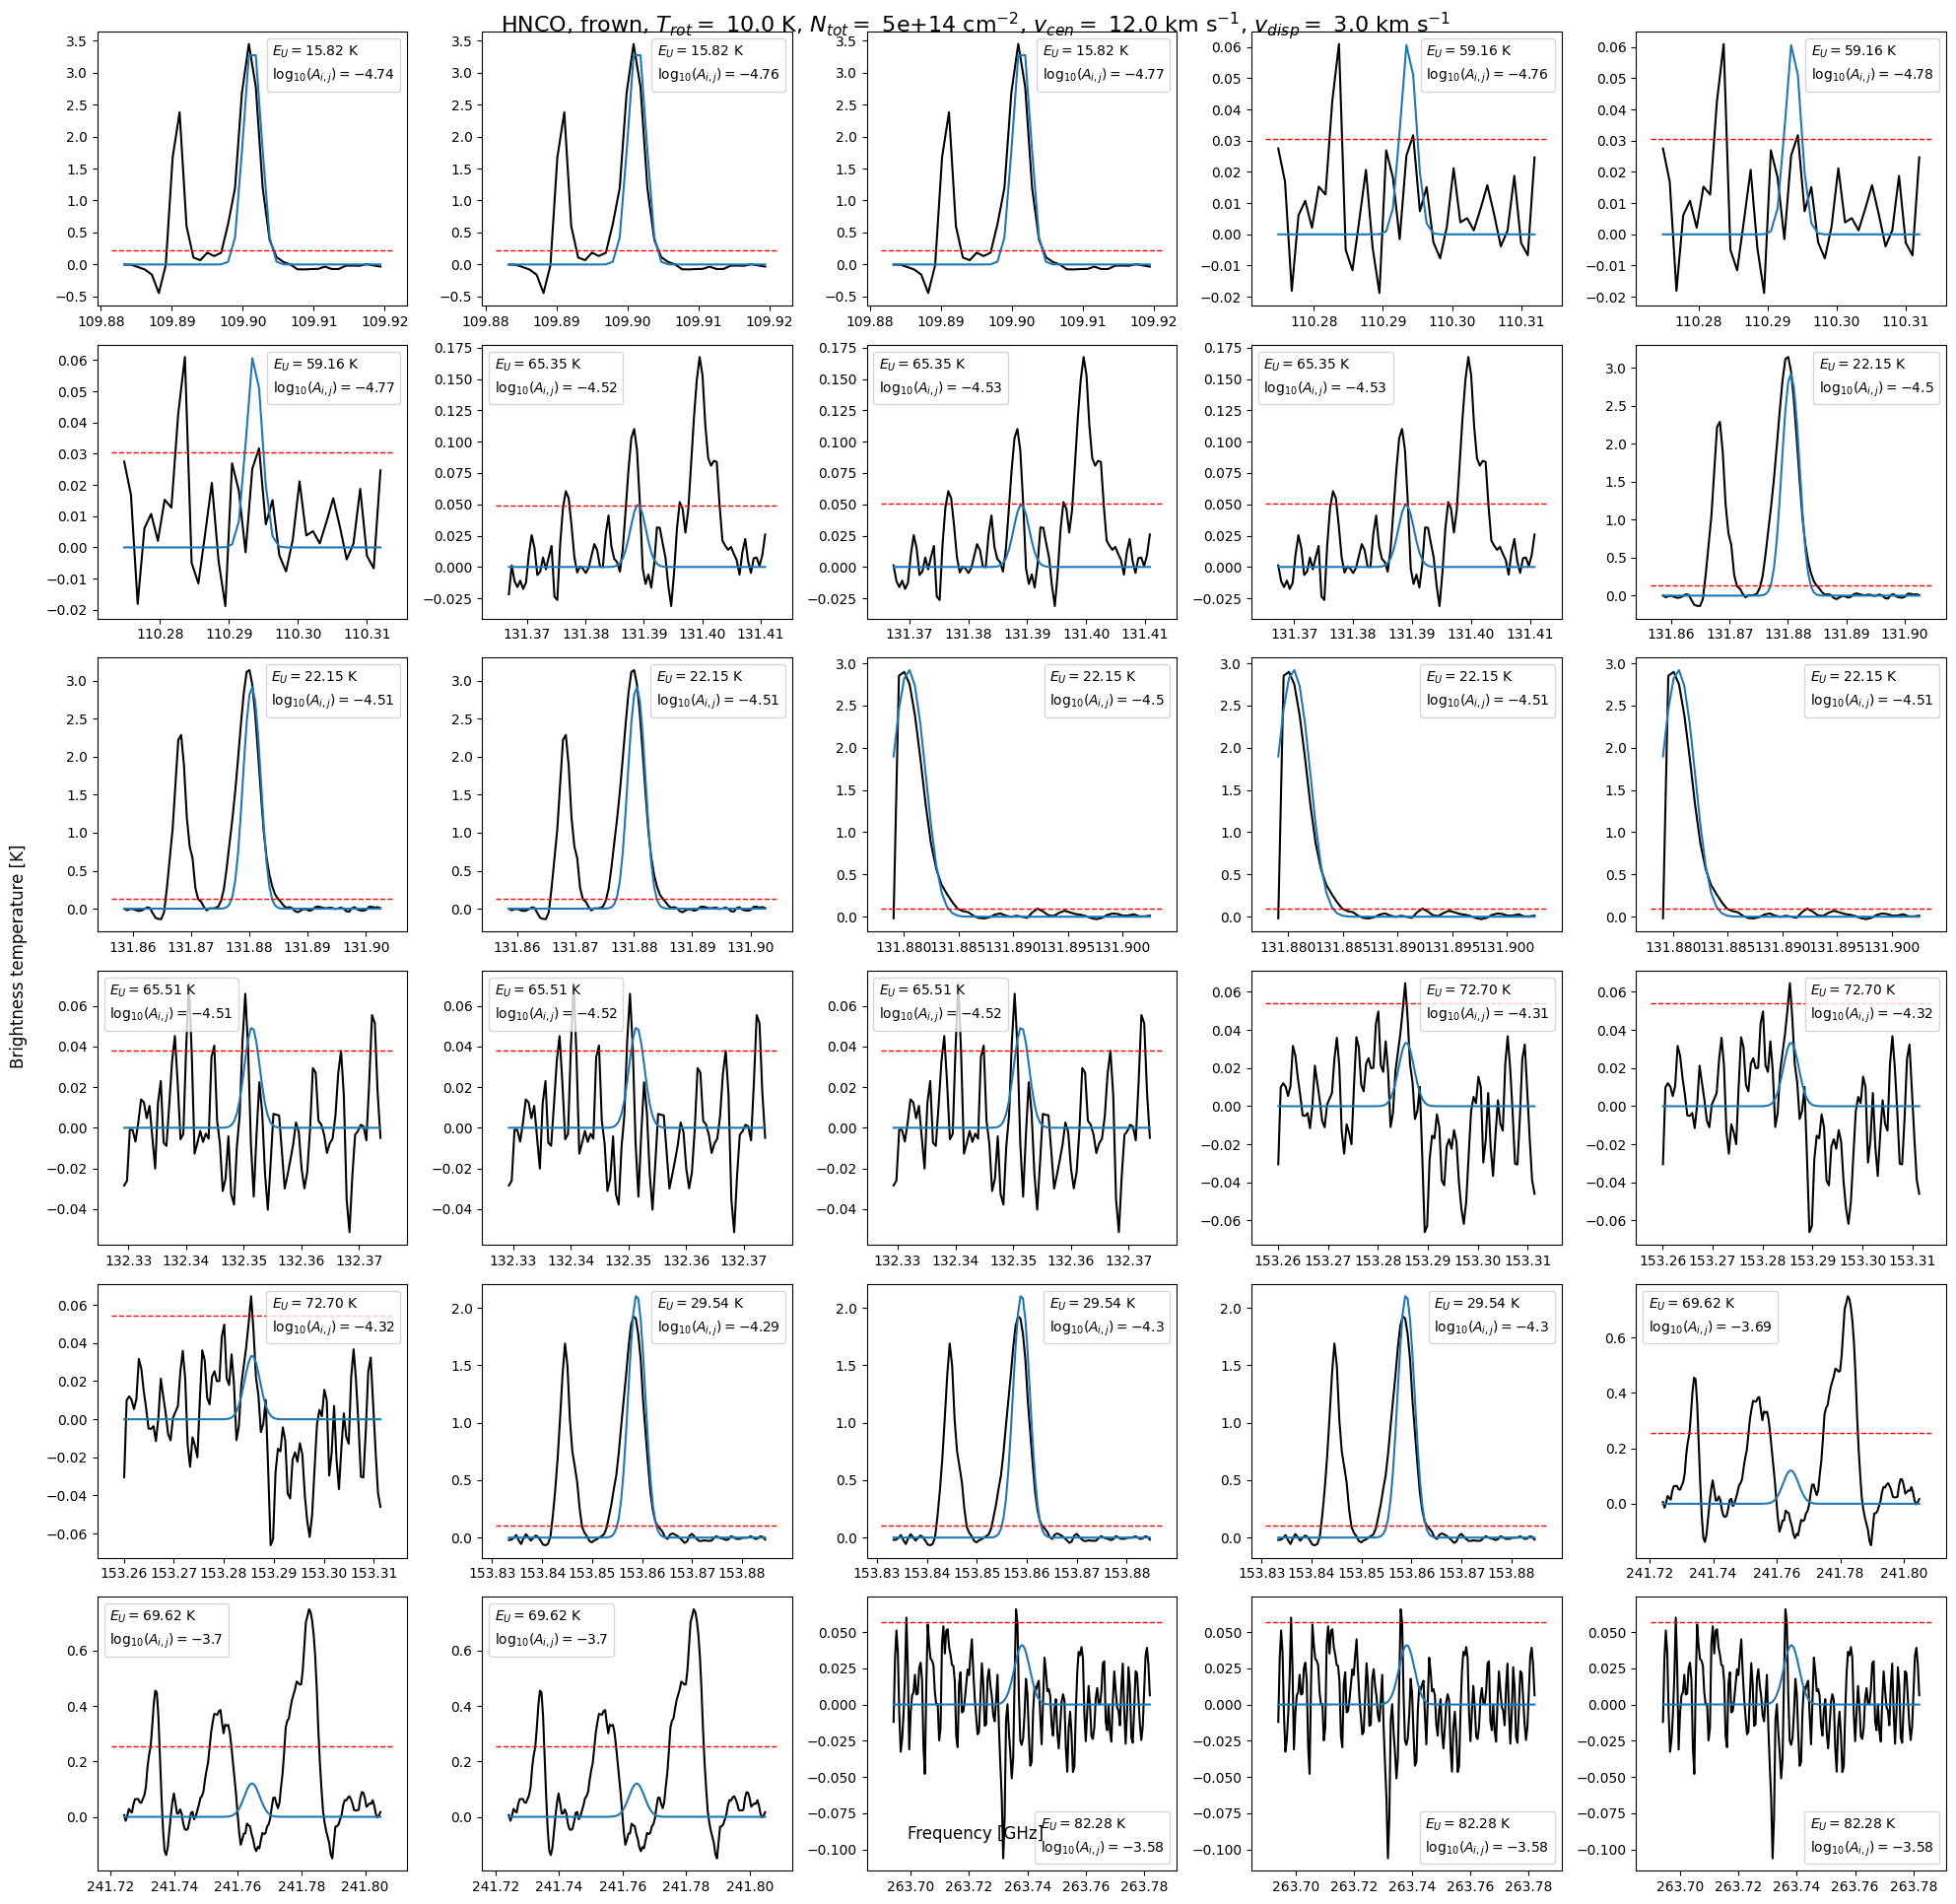

In [18]:
# Generate the model and plot the model and data spectra
EUs, log_N_upper_gs = model_and_plot(cubes_masked, temp = 10., N_tot = 5.0e+14, v_cen = 12.*u.km/u.s, v_disp = 3.*u.km/u.s,
                                     mol_name_pyspeckit=None, mol_tag_pyspeckit=mol_tag, catalog='JPL', fig_width=20, fig_height=20, 
                                     nrows=6, ncols=5, parse_loc=False, line_by_line=True, name_for_plot=f'HNCO', extr_type="reg", just_data=False,
                                     show_2_sigma=True, calc_N_uppers=True)

ValueError: Cannot have cdelt of length-0 array

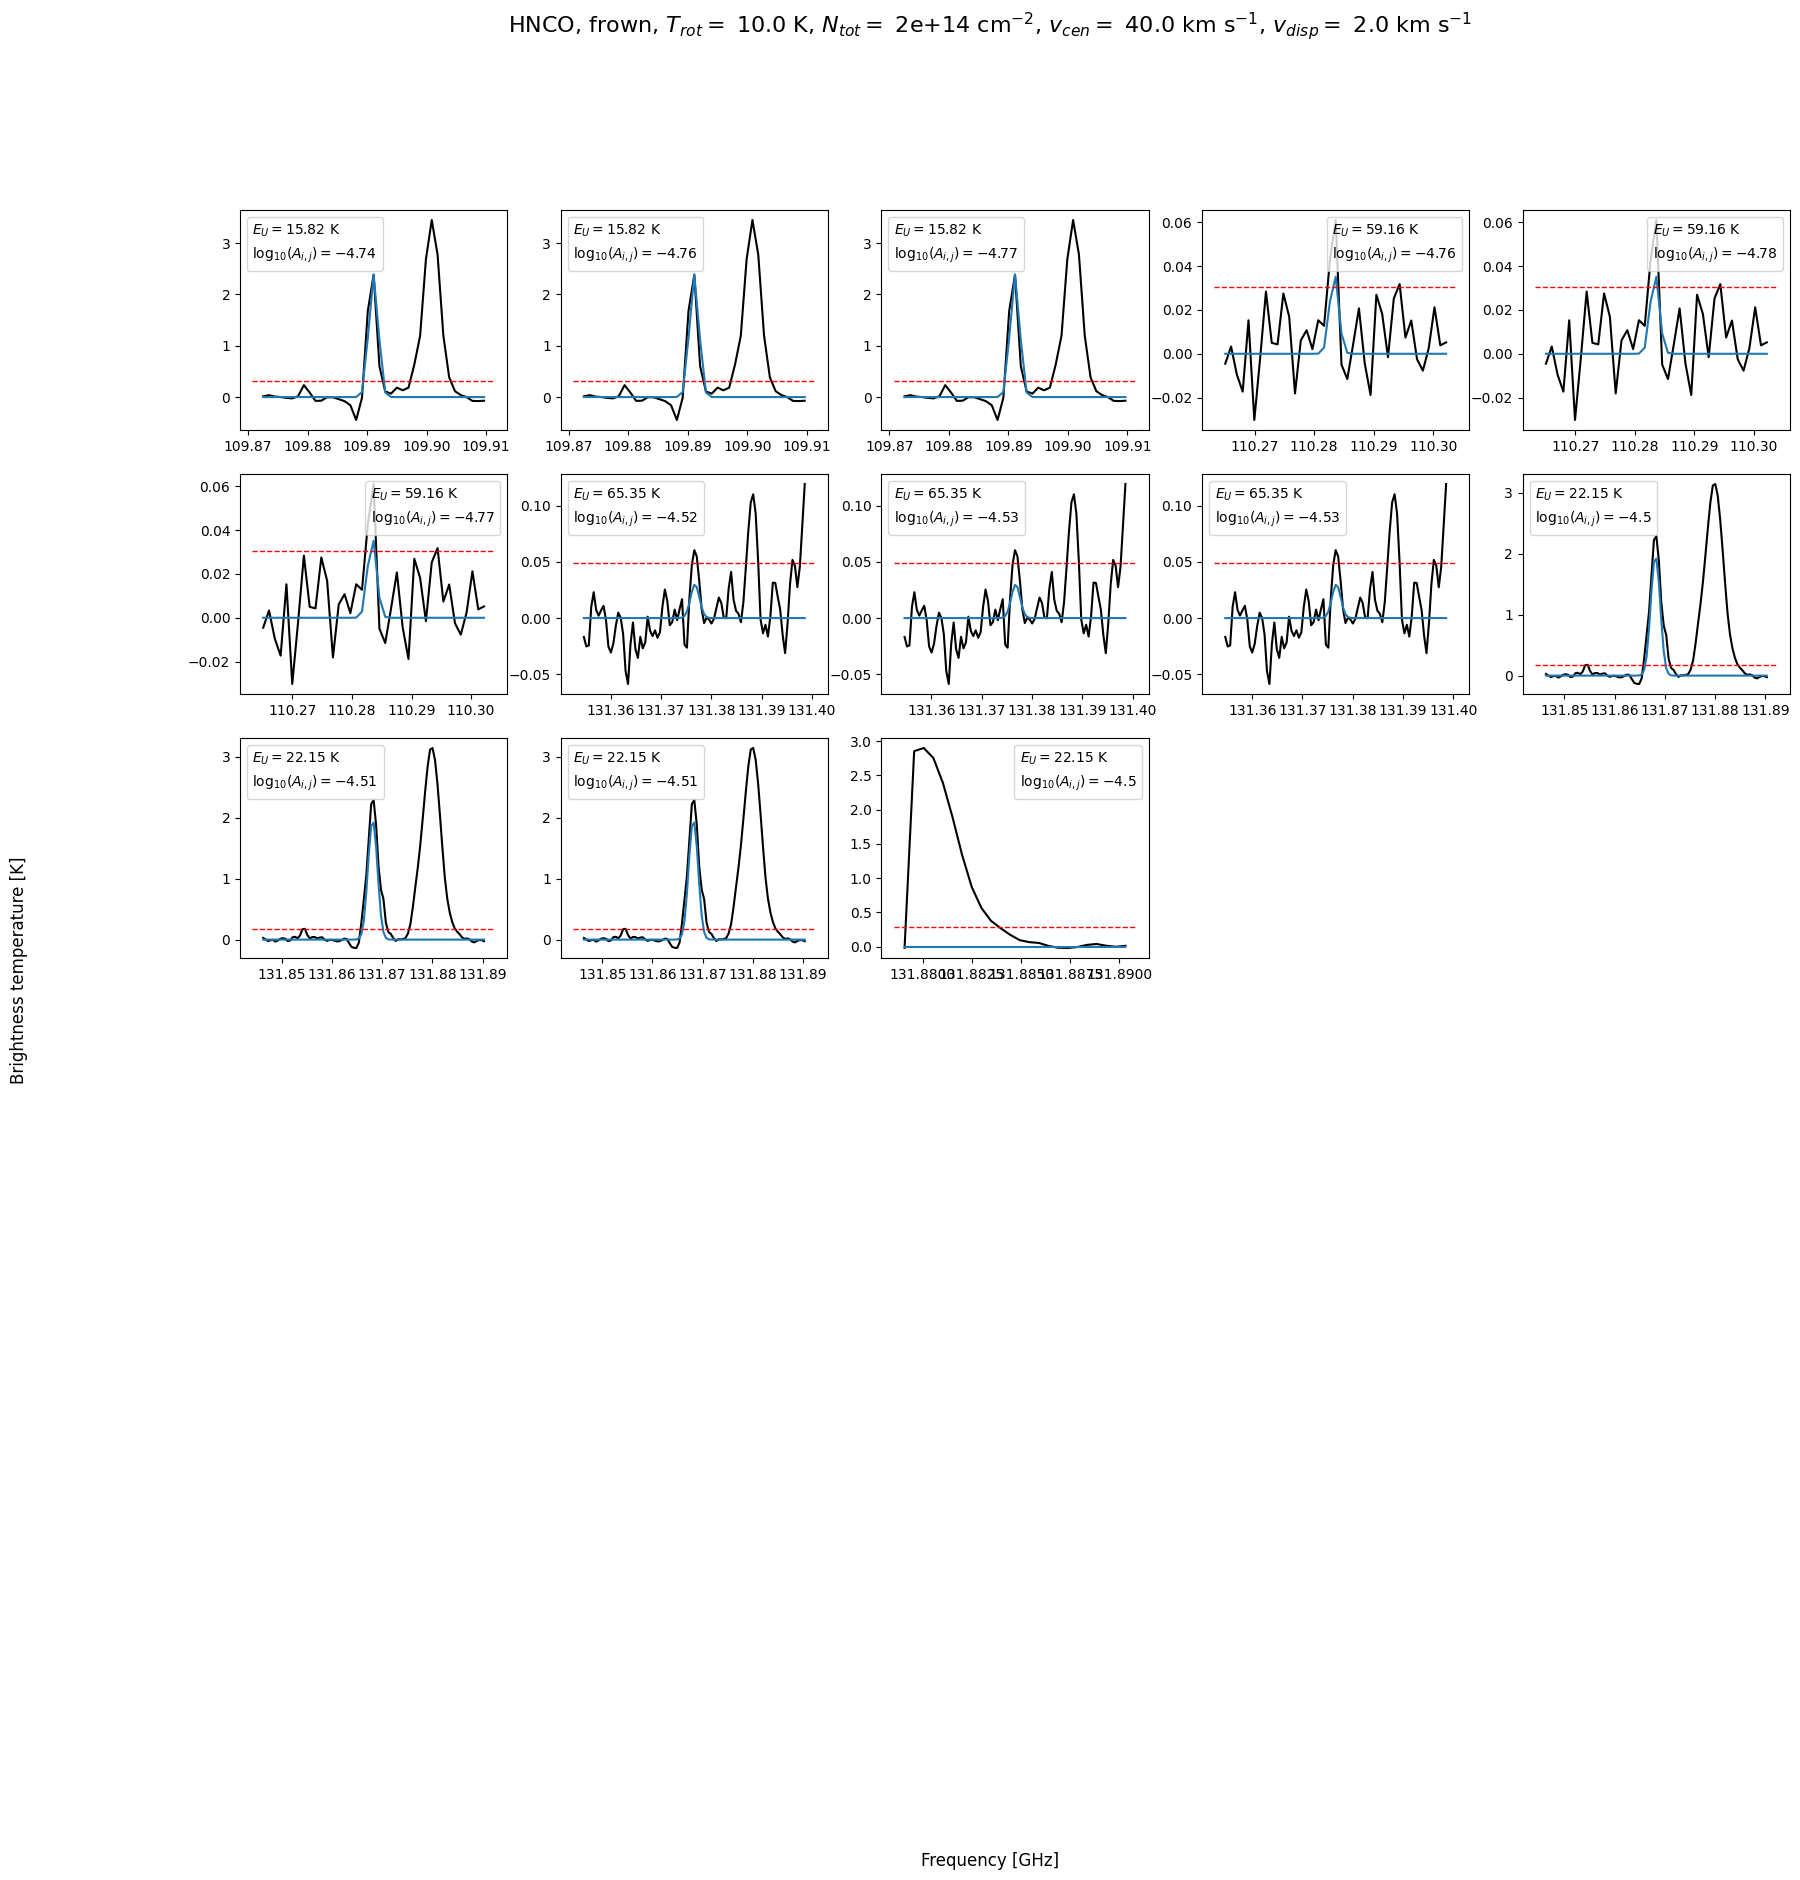

In [20]:
# Generate the model and plot the model and data spectra
log_N_upper_gs = model_and_plot(cubes_masked, temp = 10., N_tot = 2.0e+14, v_cen = 40.*u.km/u.s, v_disp = 2.*u.km/u.s,
                                mol_name_pyspeckit=None, mol_tag_pyspeckit=mol_tag, catalog='JPL', fig_width=20, fig_height=20, 
                                nrows=6, ncols=5, parse_loc=False, line_by_line=True, name_for_plot=f'HNCO', extr_type="reg",
                                show_2_sigma=True)

[ True  True  True False False False False False False  True  True  True
  True  True  True False False False False False False  True  True  True
 False False False False False False]
[15.8240443  15.8240443  15.8240443  22.1536167  22.15361706 22.15361778
 22.1536167  22.15361706 22.15361778 29.53792617 29.53792617 29.53792617]
[28.49737195 28.70506513 28.91575166 28.11966089 28.29097322 28.46343685
 27.73911232 27.91042465 28.08288828 27.3004352  27.44618883 27.59263324]


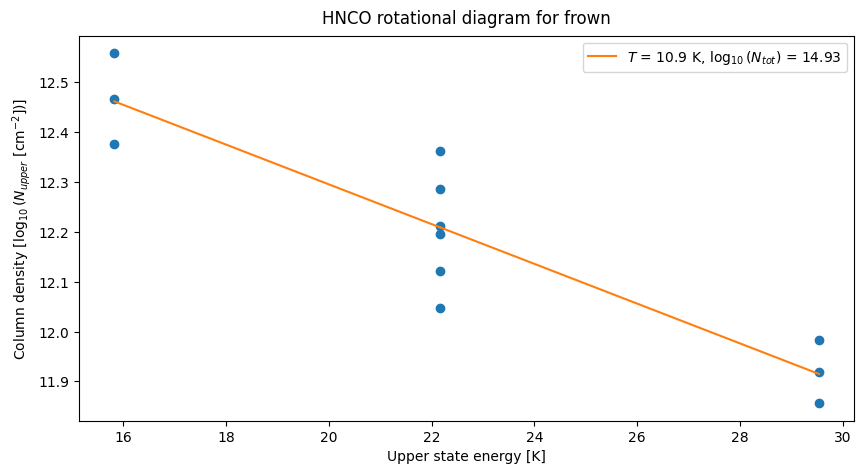

In [8]:
log_N_upper_gs = np.array(log_N_upper_gs)
ln_N_upper_gs = np.log(10.**(np.array(log_N_upper_gs)))

from scipy.optimize import curve_fit

def linear(x, m, b):
    return m*x + b

EUs_vals = np.array([EU.value for EU in EUs])

# Do the simple linear fit
# Note to self: convert to K from ergs to do the fit, because in ergs, 
# these energies are small numbers,and that can makes the fit not work

print(EUs_vals < 30.)
print(EUs_vals[EUs_vals < 30.])
print(ln_N_upper_gs[EUs_vals < 30.])
ln_N_upper_gs_new = ln_N_upper_gs[EUs_vals < 30.]
EUs_vals_new = EUs_vals[EUs_vals < 30.]
log_N_upper_gs_new = log_N_upper_gs[EUs_vals < 30.]
popt, pcov = curve_fit(linear, EUs_vals_new, ln_N_upper_gs_new) # sigma = log_N_upper_g_errs
slope, intercept = popt[0], popt[1]
temp_fit = (-1./slope)*u.K

from pyspeckit.spectrum.models.lte_molecule import get_molecular_parameters
freqs, aij, deg, EU, partfunc = get_molecular_parameters(molecule_name=None, molecule_tag=mol_tag, catalog='JPL', parse_name_locally=False,
                                                         return_table=False, fmin=80*u.GHz, fmax=100*u.GHz)

N_tot_fit = np.log10(np.exp(intercept)*partfunc(temp_fit))

### Make rotational diagram for HNCO

fig = plt.figure(figsize = (10, 5))

plt.scatter(EUs_vals_new, log_N_upper_gs_new)
plt.plot(EUs_vals_new, np.log10(np.exp(np.array(EUs_vals_new)*slope+intercept)),
         color = 'tab:orange',
         label = f"$T$ = {temp_fit:.1f}, $\log_{{10}}(N_{{tot}})$ = {N_tot_fit:.2f}")

plt.title(f"HNCO rotational diagram for frown", y = 1.01)
plt.xlabel(f"Upper state energy [K]")
plt.ylabel(f"Column density [$\log_{{10}}(N_{{upper}}\ [\mathrm{{cm}}^{{-2}}])$]")
plt.legend()

plt.show()

# plt.savefig(f"rot_diagram_x{brightest_pixel[1]}y{brightest_pixel[0]}.pdf", dpi = 200, facecolor='w', edgecolor='w', bbox_inches='tight')

In [9]:
10**(14.93)

851138038202375.9

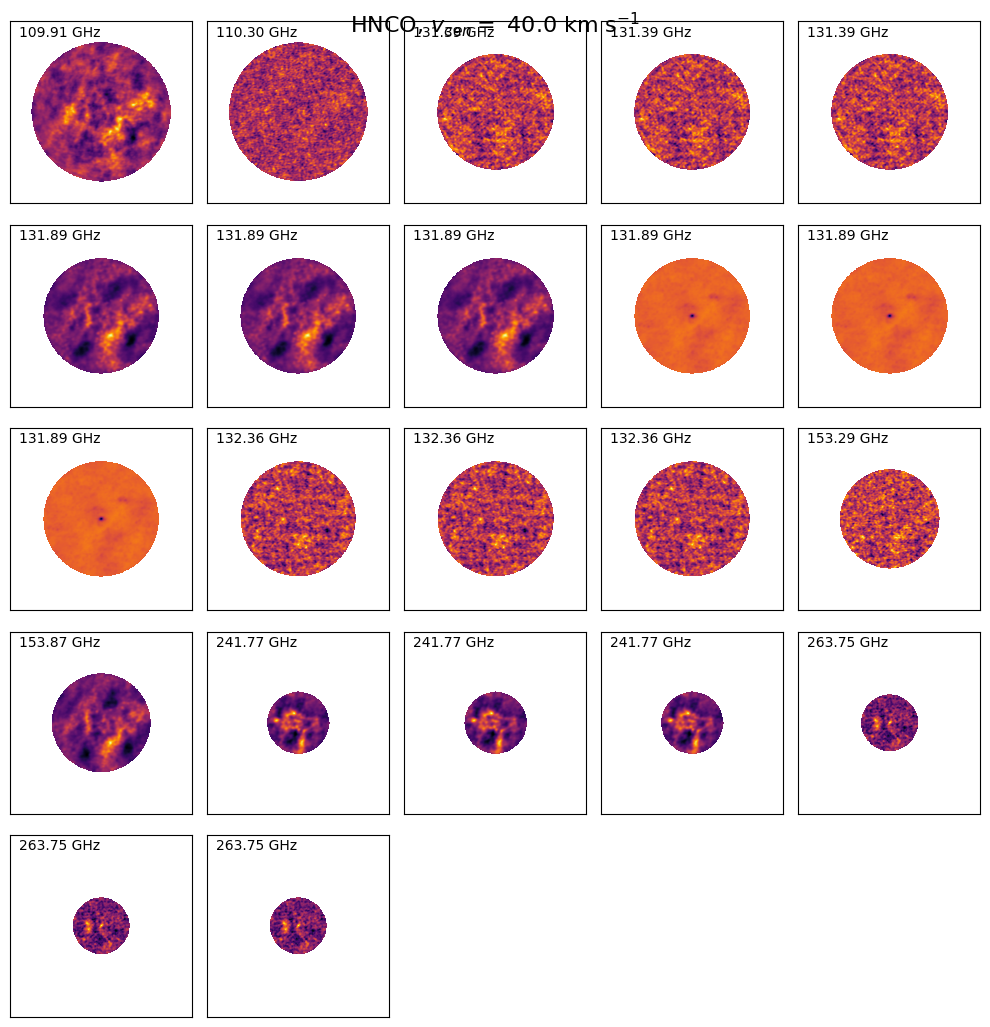

In [10]:
# Plot moment maps
plot_mom0s(cubes, freqs_mom0, v_cen=40*u.km/u.s, fig_width=10, fig_height=25, nrows=12, ncols=5, name_for_plot=f'HNCO')

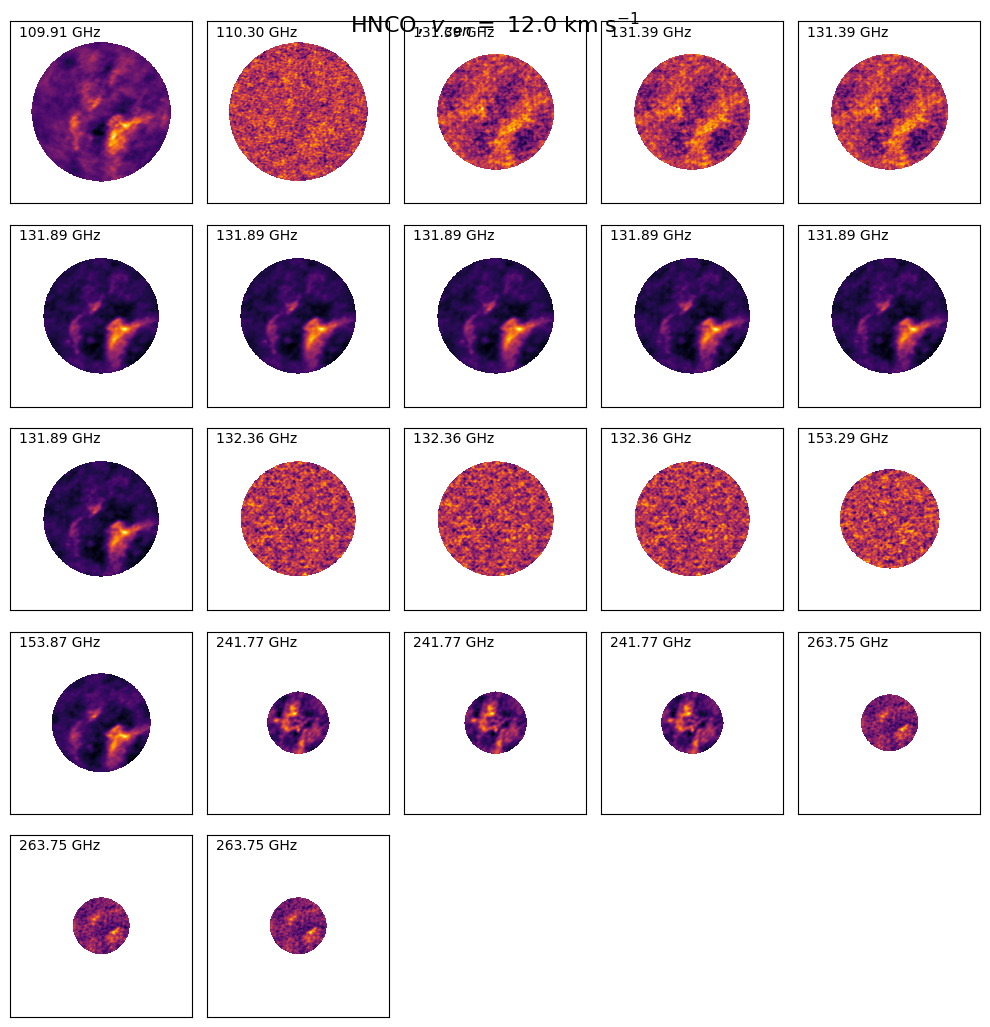

In [11]:
# Plot moment maps
plot_mom0s(cubes, freqs_mom0, v_cen=12*u.km/u.s, fig_width=10, fig_height=25, nrows=12, ncols=5, name_for_plot=f'HNCO')